In [1]:
# LeNet实现

In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import time

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.AvgPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # (14 - 5 + 1) = 10 * 10
    nn.AvgPool2d(kernel_size=2, stride=2),  # (10 - 2 + 2) / 2 = 5
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [4]:
# 模型训练
# 现在我们已经实现了LeNet，让我们看看LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.475, train acc 0.821, test acc 0.825
19619.7 examples/sec on mps
time = 74.60 secs


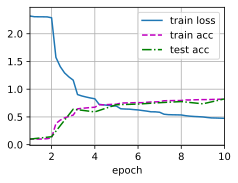

In [6]:
lr, num_epochs = 0.9, 10
start = time.time()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 0.468, train acc 0.823, test acc 0.794
19064.9 examples/sec on mps
time = 75.67 secs


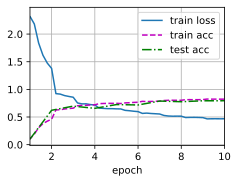

In [9]:
lr, num_epochs = 0.9, 10
start = time.time()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 0.466, train acc 0.825, test acc 0.764
5696.5 examples/sec on cpu
time = 152.99 secs


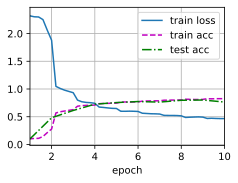

In [10]:
lr, num_epochs = 0.9, 10
start = time.time()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cpu')
end = time.time()
print(f'time = {end-start:.2f} secs')

In [ ]:
lr, num_epochs = 0.9, 10
start = time.time()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
print(f'time = {end-start:.2f} secs')

In [15]:
net2 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # (14 - 5 + 1) = 10 * 10
    nn.MaxPool2d(kernel_size=2, stride=2),  # (10 - 2 + 2) / 2 = 5
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [13]:
# 模型训练
# 现在我们已经实现了LeNet，让我们看看LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [7]:
# 由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用mps计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT 微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [8]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用mps训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)  # 初始化权重
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  # 优化算法
    loss = nn.CrossEntropyLoss()     # 损失函数
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch+ (i+1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

KeyboardInterrupt: 

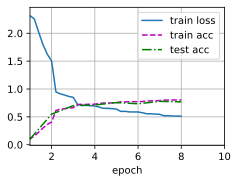

In [16]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))

loss 0.424, train acc 0.843, test acc 0.835
5213.7 examples/sec on cpu


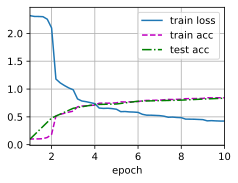

In [16]:
# MaxPool2D
d2l.train_ch6(net2, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))

In [18]:
net3 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),  # (14 - 5 + 1) = 10 * 10
    nn.MaxPool2d(kernel_size=2, stride=2),  # (10 - 2 + 2) / 2 = 5
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [4]:
import time

loss 0.258, train acc 0.903, test acc 0.876
5527.5 examples/sec on cpu
time=158.16935801506042


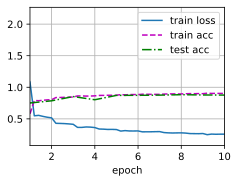

In [23]:
# Relu() and MaxPool2D
start = time.time()
d2l.train_ch6(net3, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 0.244, train acc 0.908, test acc 0.893
5199.6 examples/sec on cpu
time = 326.71 secs


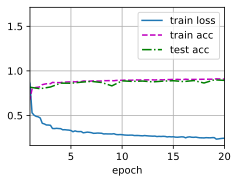

In [5]:
net4 = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3, padding=1), nn.ReLU(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(10, 20, kernel_size=3), nn.ReLU(),  # (14 - 3 + 1) = 12 * 12
    nn.MaxPool2d(kernel_size=2, stride=2),  # (12 - 2 + 2) / 2 = 6
    nn.Flatten(),
    nn.Linear(20*6*6, 240), nn.Dropout(0.5),
    nn.Linear(240, 90), nn.Sigmoid(),
    nn.Linear(90, 10),
)
# Relu() and MaxPool2D
start = time.time()
lr, num_epochs = 0.9, 20
d2l.train_ch6(net4, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 0.195, train acc 0.925, test acc 0.910
5109.9 examples/sec on cpu
time = 662.67 secs


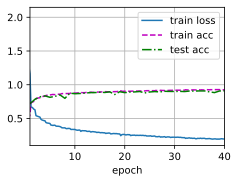

In [11]:
net4_2 = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3, padding=1), nn.ReLU(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(10, 20, kernel_size=3), nn.ReLU(),  # (14 - 3 + 1) = 12 * 12
    nn.MaxPool2d(kernel_size=2, stride=2),  # (12 - 2 + 2) / 2 = 6
    nn.Flatten(),
    nn.Linear(20*6*6, 240), nn.Sigmoid(), nn.Dropout(0.3),
    nn.Linear(240, 90), nn.Sigmoid(), nn.Dropout(0.3),
    nn.Linear(90, 10),
)
# Relu() and MaxPool2D
start = time.time()
lr, num_epochs = 0.9, 40
d2l.train_ch6(net4_2, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 0.231, train acc 0.914, test acc 0.901
5132.0 examples/sec on cpu
time = 495.70 secs


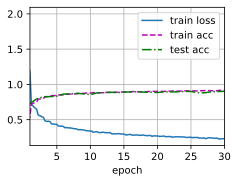

In [9]:
net4_3 = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3, padding=1), nn.ReLU(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(10, 20, kernel_size=3), nn.ReLU(),  # (14 - 3 + 1) = 12 * 12
    nn.MaxPool2d(kernel_size=2, stride=2),  # (12 - 2 + 2) / 2 = 6
    nn.Flatten(),
    nn.Linear(20*6*6, 240), nn.Sigmoid(), nn.Dropout(0.4),
    nn.Linear(240, 90), nn.Sigmoid(), nn.Dropout(0.4),
    nn.Linear(90, 10),
)
# Relu() and MaxPool2D
start = time.time()
lr, num_epochs = 0.9, 30
d2l.train_ch6(net4_3, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 0.171, train acc 0.935, test acc 0.890
1445.1 examples/sec on cpu
time = 1161.03 secs


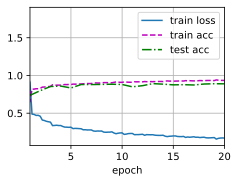

In [13]:
net5 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),  # 28 - kernel_size=5 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),  # (14 - 5 + 1) = 10 * 10
    nn.MaxPool2d(kernel_size=2, stride=2),  # (10 - 2 + 2) / 2 = 5
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)
start = time.time()
lr, num_epochs = 0.9, 20
d2l.train_ch6(net5, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))
end = time.time()
print(f'time = {end-start:.2f} secs')

loss 2.303, train acc 0.097, test acc 0.100
7068.1 examples/sec on cpu
time = 261.56 secs


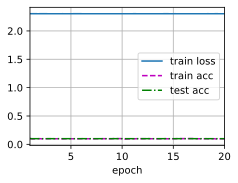

In [14]:
print(f'time = {end - start:.2f} secs')
net5 = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(),  # 28 - kernel_size=3 + padding*2 +1 = 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # (28 - 2 + 2) / 2 = 14 * 14
    nn.Conv2d(8, 16, kernel_size=3), nn.ReLU(),  # (14 - 3 + 1) = 12 * 12
    nn.MaxPool2d(kernel_size=2, stride=2),  # (12 - 2 + 2) / 2 = 6
    nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(), # 6 - 3 + 1 = 4
    nn.MaxPool2d(kernel_size=2, stride=2), # (4 -2 +2)/2 = 2
    nn.Flatten(),
    nn.Linear(32 * 2 * 2, 120), nn.ReLU(),nn.Dropout(0.5),
    nn.Linear(120, 60), nn.ReLU(),
    nn.Linear(60, 10)
)
start = time.time()
lr, num_epochs = 0.9, 20
d2l.train_ch6(net5, train_iter, test_iter, num_epochs, lr, torch.device('cpu'))
end = time.time()
print(f'time = {end - start:.2f} secs')